# Homework 4

Due date: May 26, 2024

### Submission instructions: 
- __Autograder will not be used for scoring, but you still need to submit the python file converted from this notebook (.py) and the notebook file (.ipynb) to the code submission window.__ 
To convert a Jupyter Notebook (`.ipynb`) to a regular Python script (`.py`):
  - In Jupyter Notebook: File > Download as > Python (.py)
  - In JupyterLab: File > Save and Export Notebook As... > Executable Script
  - In VS Code Jupyter Notebook App: In the toolbar, there is an Export menu. Click on it, and select Python script.
- Submit `hw4.ipynb` and `hw4.py` on Gradescope under the window "Homework 4 - code". Do **NOT** change the file name.
- Convert this notebook into a pdf file and submit it on Gradescope under the window "Homework 4 - PDF". Make sure all your code and text outputs in the problems are visible. 


### General instructions: 

In this homework, we will use pandas to build a cohort of ICU stays and visualize the results from the MIMIC-IV dataset, which you did for Homework 3 in BIOSTAT 203B. 

For processing the Parquet files, one other option is [`polars`](https://pola.rs/). The package is designed for rapid analysis of data frames, possibly larger than memory, with pandas-like syntax, Apache Arrow-based data representation and the Rust language as its backend. Syntax is similar to what you have used for `pyarrow`. You are allowed to use any method you like for analyzing data, but use of `pyarrow`, `duckdb`, or `polars` is certainly recommended for larger files to save your memory and time. (_Hint_: If you want to try `polars`, look into `scan_parquet()` and `LazyFrame`. The package `polars` supports lazy evaluation similar to what you have seen in the R `arrow` package.)

For visualization, you may use packages `matplotlib`, `seaborn`, and/or `plotly`. The use of `plotnine` is not allowed.

Please run the code below to show your system information:

In [1]:
import platform, psutil, json
def get_system_info():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        for k, v in info.items():
            print(f"{k}:\t{v}")
    except Exception as e:
        logging.exception(e)

In [2]:
get_system_info()

platform:	Darwin
platform-release:	22.6.0
platform-version:	Darwin Kernel Version 22.6.0: Wed Jul  5 22:21:53 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T6020
architecture:	arm64
processor:	arm
ram:	16 GB


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyarrow as pa
import duckdb
import plotly.express as px

## Problem 1. Visualizing patient trajectory

Visualizing a patient’s encounters in a health care system is a common task in clinical data analysis. In this question, we will visualize a patient’s ADT (admission-discharge-transfer) history and ICU vitals in the MIMIC-IV data.

### (A). ADT history
A patient’s ADT history records the time of admission, discharge, and transfer in the hospital. This figure shows the ADT history of the patient with subject_id `10001217` in the MIMIC-IV data. The x-axis is the calendar time, and the y-axis is the type of event (ADT, lab, procedure). The color of the line segment represents the care unit. The size of the line segment represents whether the care unit is an ICU/CCU. The crosses represent lab events, and the shape of the dots represents the type of procedure. The title of the figure shows the patient’s demographic information and the subtitle shows top 3 diagnoses. Try to create a figure similar to the below:

<figure>
  <img src="https://raw.githubusercontent.com/ucla-biostat-203b/2024winter/main/hw/hw3/10001217_adt.png" style="width:600px">
</figure>


Your figure does not need to be the same, but all the information in this figure should be reasonably arranged in your figure. Hint: consider using `dodge` keyword arguments of seaborn to do something similar to `jitter` of `ggplot2`. 



Hint: We need to pull information from data files `patients.csv.gz`, `admissions.csv.gz`, `transfers.csv.gz`, `labevents.csv.gz`, `procedures_icd.csv.gz`, `diagnoses_icd.csv.gz`, `d_icd_procedures.csv.gz`, and `d_icd_diagnoses.csv.gz`. For the big file `labevents.csv.gz`, use the Parquet file you generated in Homework 3. More information is available in later problems.

For reproducibility, make the Parquet file available at the current working directory, for example, by a symbolic link. Make your code reproducible using relative path.

Do a similar visualization for the patient `10013310`.

In [4]:
!ln -s /Users/yangan/Desktop/203C/labevents.parquet /Users/yangan/Desktop/203C/hw4/labevents.parquet


ln: /Users/yangan/Desktop/203C/hw4/labevents.parquet: File exists


In [5]:
!ln -s /Users/yangan/Desktop/203C/chartevents.parquet /Users/yangan/Desktop/203C/hw4/chartevents.parquet

ln: /Users/yangan/Desktop/203C/hw4/chartevents.parquet: File exists


Python: 3.11.6
Pandas: 2.0.3
Matplotlib: 3.7.2


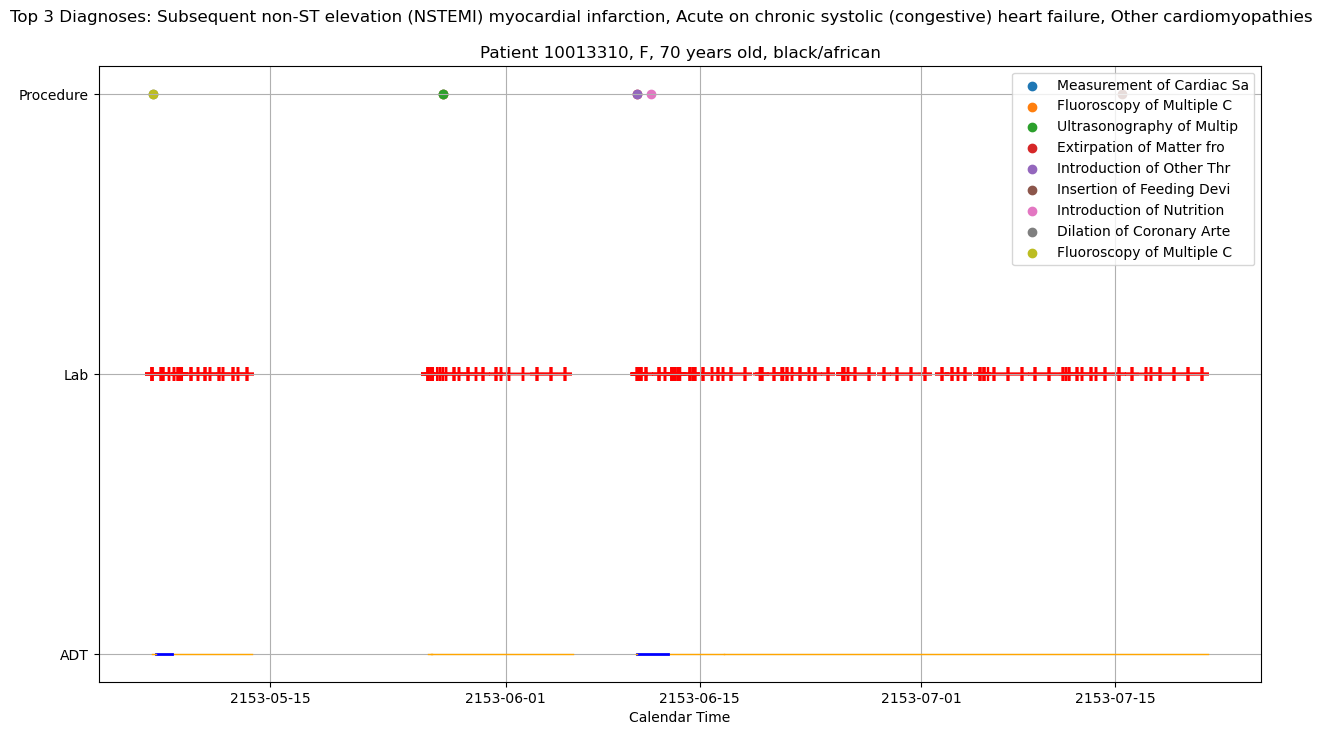

In [6]:
# Import necessary libraries
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime

# Display machine information for reproducibility
import platform
import sys
print(f'Python: {platform.python_version()}')
print(f'Pandas: {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')

# Load the data
patients = pd.read_csv("~/mimic/hosp/patients.csv.gz")
admissions = pd.read_csv("~/mimic/hosp/admissions.csv.gz")
transfers = pd.read_csv("~/mimic/hosp/transfers.csv.gz")
procedures_icd = pd.read_csv("~/mimic/hosp/procedures_icd.csv.gz")
d_icd_procedures = pd.read_csv("~/mimic/hosp/d_icd_procedures.csv.gz")
diagnoses_icd = pd.read_csv("~/mimic/hosp/diagnoses_icd.csv.gz")
d_icd_diagnoses = pd.read_csv("~/mimic/hosp/d_icd_diagnoses.csv.gz")
lab_events = pq.ParquetDataset("labevents.parquet").read().to_pandas()

# Filter data for the given subject_id
sid = 10013310
sid_info = patients[patients['subject_id'] == sid]
sid_adm = admissions[admissions['subject_id'] == sid]
sid_adt = transfers[transfers['subject_id'] == sid]
sid_lab = lab_events[lab_events['subject_id'] == sid]
sid_proc = procedures_icd[procedures_icd['subject_id'] == sid].merge(d_icd_procedures, on=['icd_code', 'icd_version'], how='left')
sid_diag = diagnoses_icd[diagnoses_icd['subject_id'] == sid].merge(d_icd_diagnoses, on=['icd_code', 'icd_version'], how='left')

# Convert time columns to datetime
sid_adt.loc[:, 'intime'] = pd.to_datetime(sid_adt['intime'])
sid_adt.loc[:, 'outtime'] = pd.to_datetime(sid_adt['outtime'])
sid_lab.loc[:, 'charttime'] = pd.to_datetime(sid_lab['charttime'])
sid_proc.loc[:, 'chartdate'] = pd.to_datetime(sid_proc['chartdate'])

# Filter out rows with NaN values in careunit to avoid TypeError
sid_adt = sid_adt.dropna(subset=['careunit'])

# Plot
plt.figure(figsize=(15, 8))

# Plot ADT history
for _, row in sid_adt.iterrows():
    plt.plot([row['intime'], row['outtime']], ['ADT', 'ADT'], color='blue' if 'ICU' in row['careunit'] or 'CCU' in row['careunit'] else 'orange', linewidth=2 if 'ICU' in row['careunit'] or 'CCU' in row['careunit'] else 1)

# Plot Lab events
plt.scatter(sid_lab['charttime'], ['Lab'] * len(sid_lab), color='red', marker='+', s=100)

# Plot Procedure events
for _, row in sid_proc.iterrows():
    plt.scatter(row['chartdate'] + pd.Timedelta(hours=12), 'Procedure', label=row['long_title'][:25])

# Title and labels
plt.title(f"Patient {sid}, {sid_info['gender'].values[0]}, {sid_info['anchor_age'].values[0] + pd.to_datetime(sid_adm['admittime'].values[0]).year - sid_info['anchor_year'].values[0]} years old, {sid_adm['race'].values[0].lower()}")
plt.suptitle(f"Top 3 Diagnoses: {', '.join(sid_diag['long_title'][:3])}", y=0.95)
plt.xlabel("Calendar Time")
plt.yticks(['ADT', 'Lab', 'Procedure'], ['ADT', 'Lab', 'Procedure'])
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


### (B). ICU stays
ICU stays are a subset of ADT history. This figure shows the vitals of the patient `10001217` during ICU stays. The x-axis is the calendar time, and the y-axis is the value of the vital. The color of the line represents the type of vital. The facet grid shows the abbreviation of the vital and the stay ID. These vitals are: heart rate (220045), systolic non-invasive blood pressure (220179), diastolic non-invasive blood pressure (220180), body temperature in Fahrenheit (223761), and respiratory rate (220210). Try to create a figure similar to below:


<figure>
  <img src="https://raw.githubusercontent.com/ucla-biostat-203b/2024winter/main/hw/hw3/10001217_icu.png" style="width:600px">
</figure>

Repeat a similar visualization for the patient `10013310`.

/opt/anaconda3/envs/BIOSTAT203C-24S/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/anaconda3/envs/BIOSTAT203C-24S/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


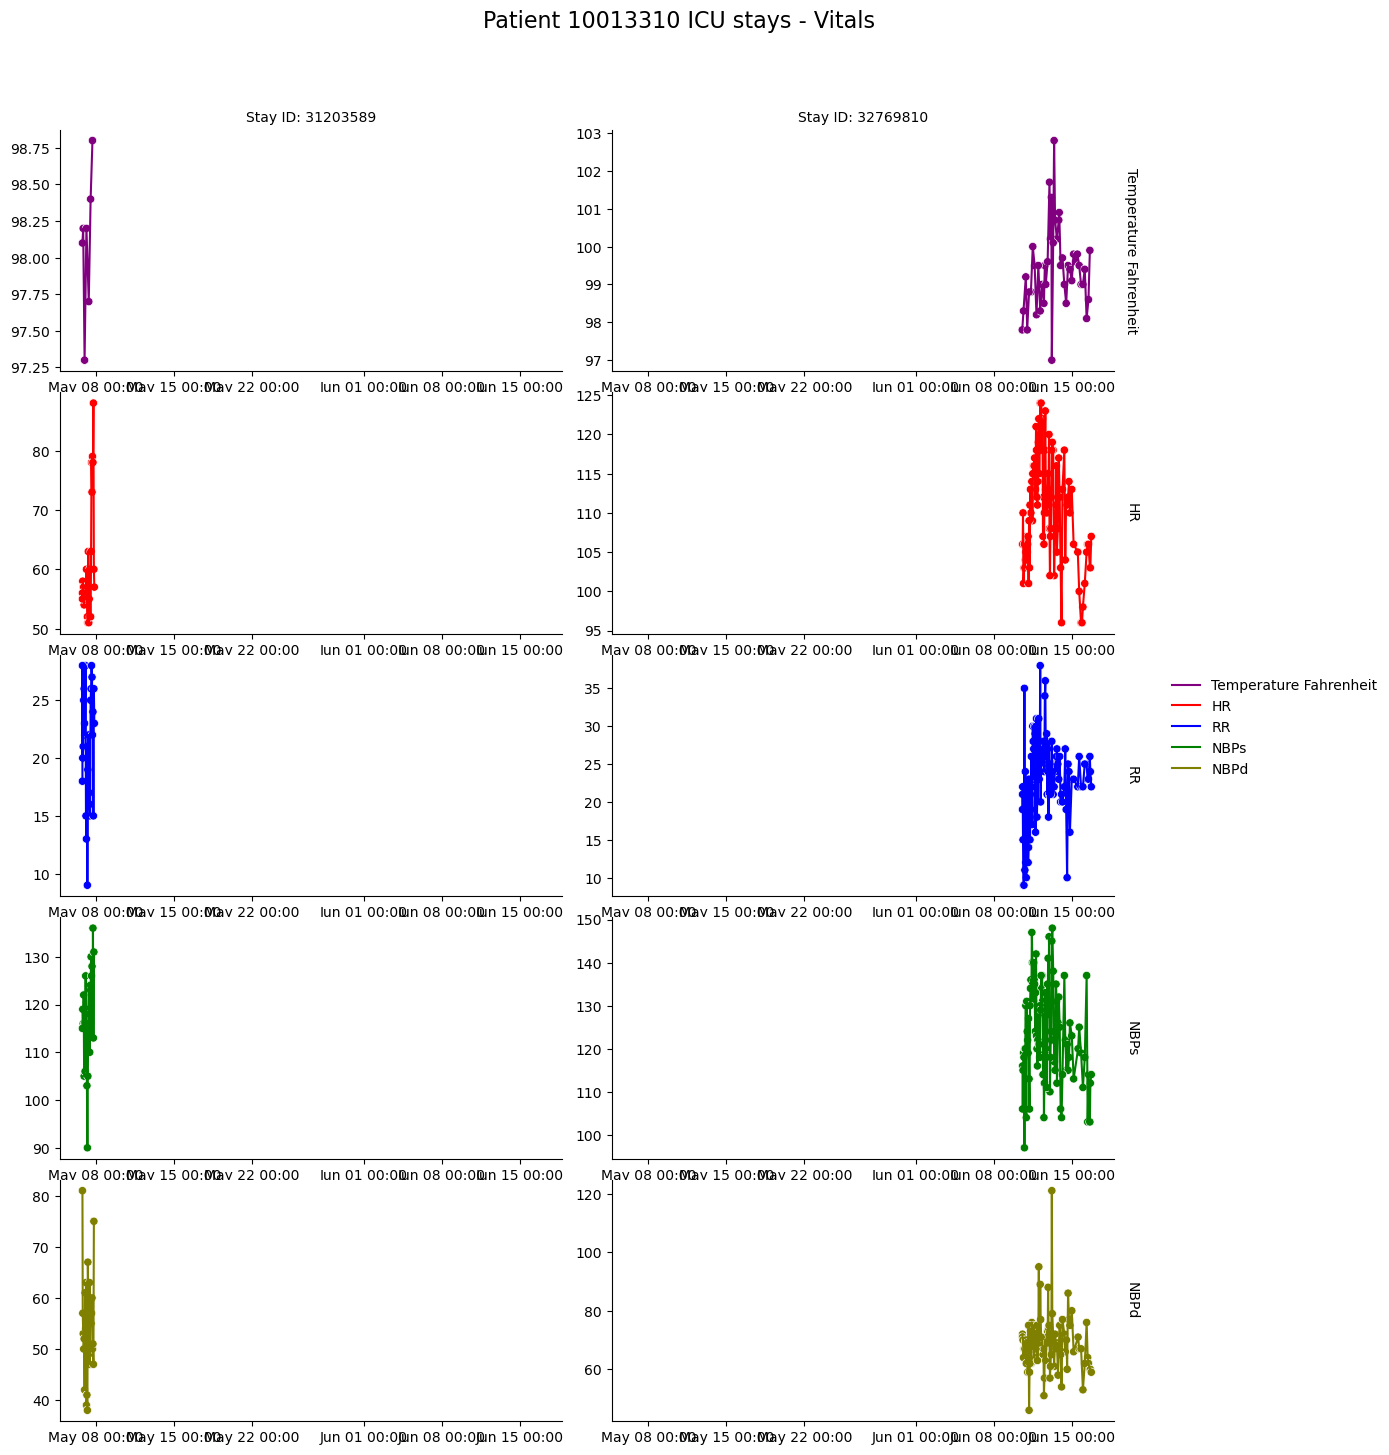

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the subject ID
sid = 10013310

# Load the ICU stays and chart events data
sid_icu = pd.read_csv("~/mimic/icu/icustays.csv.gz")
sid_chart = pq.ParquetDataset("chartevents.parquet").read().to_pandas()

# Filter the data for the given subject ID
sid_icu = sid_icu[sid_icu['subject_id'] == sid]
sid_chart = sid_chart[(sid_chart['subject_id'] == sid) & 
                      (sid_chart['itemid'].isin([220045, 220180, 220179, 223761, 220210]))]

# Merge the ICU stays data with the chart events data
merged_data = pd.merge(sid_icu, sid_chart, on='stay_id')

# Map item IDs to labels
item_labels = {
    220045: 'HR',
    220180: 'NBPd',
    220179: 'NBPs',
    220210: 'RR',
    223761: 'Temperature Fahrenheit'
}
merged_data['item_label'] = merged_data['itemid'].map(item_labels)

# Convert charttime to datetime
merged_data['charttime'] = pd.to_datetime(merged_data['charttime'])

# Plot
palette = {
    'HR': 'red',
    'NBPd': 'olive',
    'NBPs': 'green',
    'RR': 'blue',
    'Temperature Fahrenheit': 'purple'
}

g = sns.FacetGrid(merged_data, row='item_label', col='stay_id', margin_titles=True, height=3, aspect=2, sharey=False)
g.map_dataframe(sns.lineplot, x='charttime', y='valuenum', hue='item_label', palette=palette)
g.map_dataframe(sns.scatterplot, x='charttime', y='valuenum', hue='item_label', palette=palette, legend=False)

g.set_axis_labels('', '')
g.set_titles(col_template='Stay ID: {col_name}', row_template='{row_name}')
g.add_legend()

for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d %H:%M'))

plt.subplots_adjust(top=0.9)
g.fig.suptitle(f'Patient {sid} ICU stays - Vitals', fontsize=16)

plt.show()


## Problem 2. ICU stays

`icustays.csv.gz` (https://mimic.mit.edu/docs/iv/modules/icu/icustays/) contains data about Intensive Care Units (ICU) stays. The first 10 lines are:

In [2]:
!zcat < ~/mimic/icu/icustays.csv.gz | head

subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.4102662037037037
10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.4975347222222222
10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.1180324074074075
10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.9481134259259258
10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338587962962963
10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:

### (A). Ingestion

Import `icustays.csv.gz` as a DataFrame `icustays_df`.

In [3]:
import pandas as pd

# Path to the compressed CSV file
file_path = '~/mimic/icu/icustays.csv.gz'

# Import the compressed CSV file as a DataFrame
icustays_df = pd.read_csv(file_path, compression='gzip')

# Display the first few rows of the DataFrame to confirm successful import
print(icustays_df.head())


   subject_id   hadm_id   stay_id  \
0    10000032  29079034  39553978   
1    10000980  26913865  39765666   
2    10001217  24597018  37067082   
3    10001217  27703517  34592300   
4    10001725  25563031  31205490   

                                     first_careunit  \
0                Medical Intensive Care Unit (MICU)   
1                Medical Intensive Care Unit (MICU)   
2               Surgical Intensive Care Unit (SICU)   
3               Surgical Intensive Care Unit (SICU)   
4  Medical/Surgical Intensive Care Unit (MICU/SICU)   

                                      last_careunit               intime  \
0                Medical Intensive Care Unit (MICU)  2180-07-23 14:00:00   
1                Medical Intensive Care Unit (MICU)  2189-06-27 08:42:00   
2               Surgical Intensive Care Unit (SICU)  2157-11-20 19:18:02   
3               Surgical Intensive Care Unit (SICU)  2157-12-19 15:42:24   
4  Medical/Surgical Intensive Care Unit (MICU/SICU)  2110-04-11 15

### (B). Summary and visualization

How many unique `subject_id`? Can a `subject_id` have multiple ICU stays? Summarize the number of ICU stays per `subject_id` by graphs.

In [4]:
import pandas as pd

file_path = '~/mimic/icu/icustays.csv.gz'
icustays_df = pd.read_csv(file_path, compression='gzip')


In [5]:
# Count unique subject_ids
unique_subjects = icustays_df['subject_id'].nunique()
print("Number of unique subject_ids:", unique_subjects)

# Check if a subject_id can have multiple ICU stays
icu_stays_per_subject = icustays_df['subject_id'].value_counts()
multiple_icu_stays = icu_stays_per_subject[icu_stays_per_subject > 1].count()
print("Number of subject_ids with multiple ICU stays:", multiple_icu_stays)


Number of unique subject_ids: 50920
Number of subject_ids with multiple ICU stays: 12448


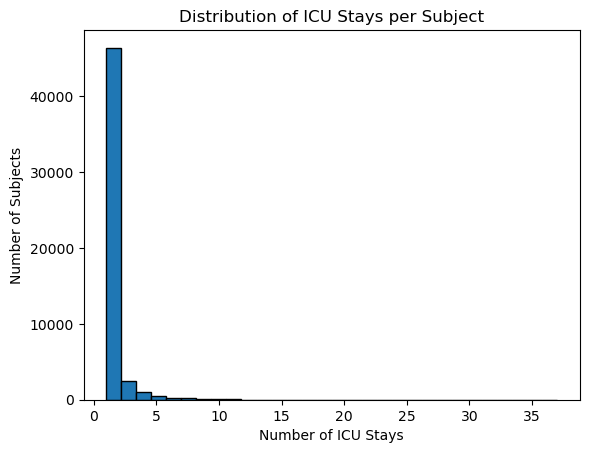

In [6]:
import matplotlib.pyplot as plt

# Plot the distribution of ICU stays per subject_id
icu_stays_per_subject.hist(bins=30, edgecolor='black')
plt.title('Distribution of ICU Stays per Subject')
plt.xlabel('Number of ICU Stays')
plt.ylabel('Number of Subjects')
plt.grid(False)
plt.show()


Number of Unique Subject IDs
Unique Subject IDs: 50,920
Subjects with Multiple ICU Stays: 12,448
Summary and Visualization
The histogram provided illustrates the distribution of ICU stays per subject. Most subjects have a single ICU stay, while a smaller subset of subjects has multiple ICU stays. Here’s a detailed analysis:
Single ICU Stay: The vast majority of subjects have only one ICU stay, as evidenced by the tall bar at 1 on the x-axis.
Multiple ICU Stays: There are progressively fewer subjects with more ICU stays. The histogram shows a steep decline, indicating that having multiple ICU stays is relatively uncommon.
Outliers: A few subjects have a large number of ICU stays (up to 36), which is rare but highlights patients with chronic or severe conditions requiring repeated ICU admissions.
Conclusion
The histogram effectively demonstrates that while most patients have a single ICU stay, a significant number of patients have multiple ICU stays. This data is crucial for understanding patient demographics and can aid in resource allocation and planning within the ICU.

## Problem 3. `admissions` data

Information of the patients admitted into hospital is available in `admissions.csv.gz`. See https://mimic.mit.edu/docs/iv/modules/hosp/admissions/ for details of each field in this file. The first 10 lines are

In [9]:
!zcat < ~/mimic/hosp/admissions.csv.gz | head

subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,,EU OBSERVATION,P51VDL,EMERGENCY ROOM,,Other,ENGLISH,SINGLE,WHIT

### (A). Ingestion
Import `admissions.csv.gz` as a data frame `admissions_df`.

In [10]:
import pandas as pd

# Path to the compressed CSV file
file_path = '~/mimic/hosp/admissions.csv.gz'

# Import the compressed CSV file as a DataFrame
admissions_df = pd.read_csv(file_path, compression='gzip')

# Display the first few rows of the DataFrame to confirm successful import
print(admissions_df.head())


   subject_id   hadm_id            admittime            dischtime deathtime  \
0    10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00       NaN   
1    10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00       NaN   
2    10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00       NaN   
3    10000032  29079034  2180-07-23 12:35:00  2180-07-25 17:55:00       NaN   
4    10000068  25022803  2160-03-03 23:16:00  2160-03-04 06:26:00       NaN   

   admission_type admit_provider_id      admission_location  \
0          URGENT            P874LG  TRANSFER FROM HOSPITAL   
1        EW EMER.            P09Q6Y          EMERGENCY ROOM   
2        EW EMER.            P60CC5          EMERGENCY ROOM   
3        EW EMER.            P30KEH          EMERGENCY ROOM   
4  EU OBSERVATION            P51VDL          EMERGENCY ROOM   

  discharge_location insurance language marital_status   race  \
0               HOME     Other  ENGLISH        WIDOWED  WHITE   
1               

### (B). Summary and visualization

Summarize the following information by graphics and explain any patterns you see.

- number of admissions per patient
- admission hour of day (anything unusual?)
- admission minute (anything unusual?)
- length of hospital stay (from admission to discharge) (anything unusual?)

According to the MIMIC-IV documentation:

> All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future. Dates of birth which occur in the present time are not true dates of birth. Furthermore, dates of birth which occur before the year 1900 occur if the patient is older than 89. In these cases, the patient’s age at their first admission has been fixed to 300.

Step 1: Import Libraries and Data

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = '~/mimic/hosp/admissions.csv.gz'
admissions_df = pd.read_csv(file_path, compression='gzip')


Step 2: Prepare Data for Visualization
A. Number of Admissions Per Patient

In [12]:
admissions_per_patient = admissions_df['subject_id'].value_counts()


B. Admission Hour of Day
extract the hour from the admittime column:

In [13]:
admissions_df['admission_hour'] = pd.to_datetime(admissions_df['admittime']).dt.hour


C. Admission Minute
extract the minute from the admittime:

In [14]:
admissions_df['admission_minute'] = pd.to_datetime(admissions_df['admittime']).dt.minute


D. Length of Hospital Stay
Calculate the difference between dischtime and admittime:

In [15]:
admissions_df['length_of_stay'] = pd.to_datetime(admissions_df['dischtime']) - pd.to_datetime(admissions_df['admittime'])
admissions_df['length_of_stay_hours'] = admissions_df['length_of_stay'].dt.total_seconds() / 3600  # Convert to hours


Step 3: Visualize the Data
A. Number of Admissions Per Patient

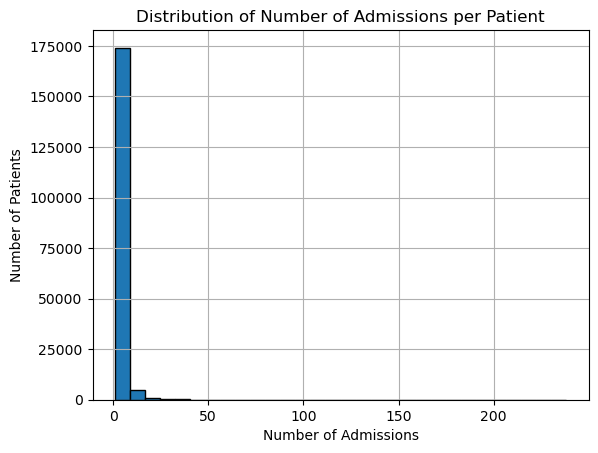

In [16]:
admissions_per_patient.hist(bins=30, edgecolor='black')
plt.title('Distribution of Number of Admissions per Patient')
plt.xlabel('Number of Admissions')
plt.ylabel('Number of Patients')
plt.show()


B. Admission Hour of Day

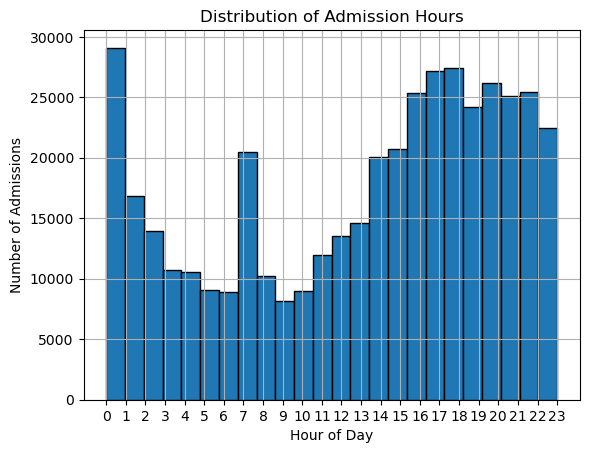

In [17]:
admissions_df['admission_hour'].hist(bins=24, edgecolor='black')
plt.title('Distribution of Admission Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Admissions')
plt.xticks(range(0, 24, 1))
plt.show()


C. Admission Minute

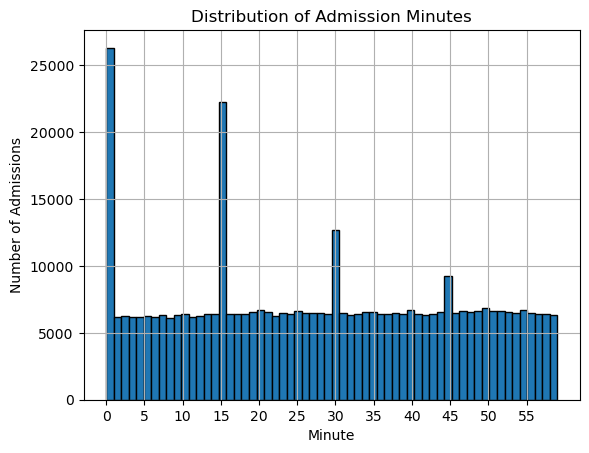

In [18]:
admissions_df['admission_minute'].hist(bins=60, edgecolor='black')
plt.title('Distribution of Admission Minutes')
plt.xlabel('Minute')
plt.ylabel('Number of Admissions')
plt.xticks(range(0, 60, 5))
plt.show()


D. Length of Hospital Stay

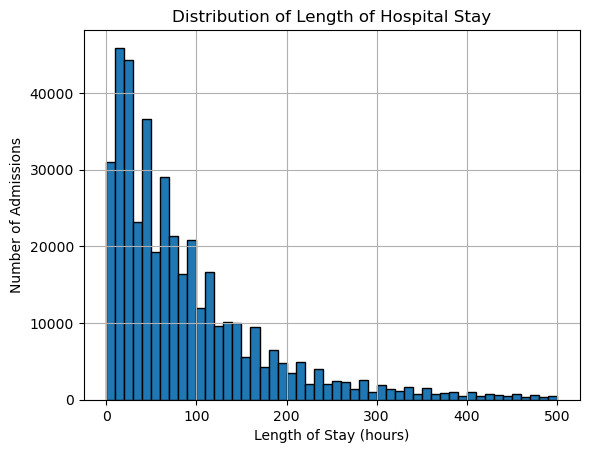

In [19]:
admissions_df['length_of_stay_hours'].hist(bins=50, edgecolor='black', range=[0, 500])  # Limiting to 500 hours for better visualization
plt.title('Distribution of Length of Hospital Stay')
plt.xlabel('Length of Stay (hours)')
plt.ylabel('Number of Admissions')
plt.show()


Summary and Visualization Analysis
1. Number of Admissions per Patient
Analysis:
The histogram shows the distribution of the number of admissions per patient.
Most patients have a single admission, with a steep drop-off for patients with multiple admissions.
There are a few outliers with a very high number of admissions, which could indicate patients with chronic conditions requiring frequent hospital visits.
2. Admission Hour of Day
Analysis:
The distribution of admissions over the hours of the day shows some patterns.
There are peaks around midnight and early morning hours (1-2 AM), which might be due to patients being admitted overnight or following emergencies.
Another significant peak occurs around the late afternoon to evening hours (4-8 PM).
A noticeable dip occurs around 6-8 AM, possibly due to shift changes or fewer planned admissions during these hours.
3. Admission Minute
Analysis:
The histogram shows the distribution of admissions by the minute of the hour.
There are spikes at regular intervals (0, 15, 30, 45 minutes), which might suggest a pattern in data entry practices or scheduled admissions.
This pattern could also indicate rounding off times to the nearest quarter hour.
4. Length of Hospital Stay
Analysis:
The histogram shows the distribution of the length of hospital stays from admission to discharge.
The distribution is right-skewed, with most stays being relatively short (less than 100 hours).
There are fewer long-term stays, but they extend up to several hundred hours, indicating a minority of patients with prolonged hospitalizations.
Summary
Number of Admissions per Patient:
Most patients have only one admission.
A small number of patients have multiple admissions, potentially indicating chronic or recurring conditions.
Admission Hour of Day:
Peaks in admissions at specific times of the day (midnight, early morning, and late afternoon).
Dips in the early morning hours, possibly due to fewer scheduled admissions.
Admission Minute:
Spikes at regular intervals (every 15 minutes), suggesting patterns in data entry or scheduling.
Length of Hospital Stay:
Right-skewed distribution with most stays being short.
Some patients have significantly longer stays, indicating more severe or complex medical needs.
Interpretation of Patterns
These visualizations provide insights into hospital admission practices and patient demographics. Regular intervals in admission times might suggest structured admission processes, while the variability in the length of stay highlights the diversity of patient conditions and treatment requirements. Analyzing these patterns can help in resource planning and optimizing hospital operations.

## Problem 4. `patients` data
Patient information is available in `patients.csv.gz`. See https://mimic.mit.edu/docs/iv/modules/hosp/patients/ for details of each field in this file. The first 10 lines are:

In [20]:
!zcat < ~/mimic/hosp/patients.csv.gz | head

subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
10000032,F,52,2180,2014 - 2016,2180-09-09
10000048,F,23,2126,2008 - 2010,
10000068,F,19,2160,2008 - 2010,
10000084,M,72,2160,2017 - 2019,2161-02-13
10000102,F,27,2136,2008 - 2010,
10000108,M,25,2163,2014 - 2016,
10000115,M,24,2154,2017 - 2019,
10000117,F,48,2174,2008 - 2010,
10000178,F,59,2157,2017 - 2019,
zcat: error writing to output: Broken pipe


### (A). Ingestion
Import `patients.csv.gz` (https://mimic.mit.edu/docs/iv/modules/hosp/patients/) as a data frame `patients_df`.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = '~/mimic/hosp/patients.csv.gz'
patients_df = pd.read_csv(file_path, compression='gzip')

# Display the first few rows to confirm it's loaded correctly
print(patients_df.head())


   subject_id gender  anchor_age  anchor_year anchor_year_group         dod
0    10000032      F          52         2180       2014 - 2016  2180-09-09
1    10000048      F          23         2126       2008 - 2010         NaN
2    10000068      F          19         2160       2008 - 2010         NaN
3    10000084      M          72         2160       2017 - 2019  2161-02-13
4    10000102      F          27         2136       2008 - 2010         NaN


### (B). Summary and visaulization
Summarize variables `gender` and `anchor_age` by graphics, and explain any patterns you see.

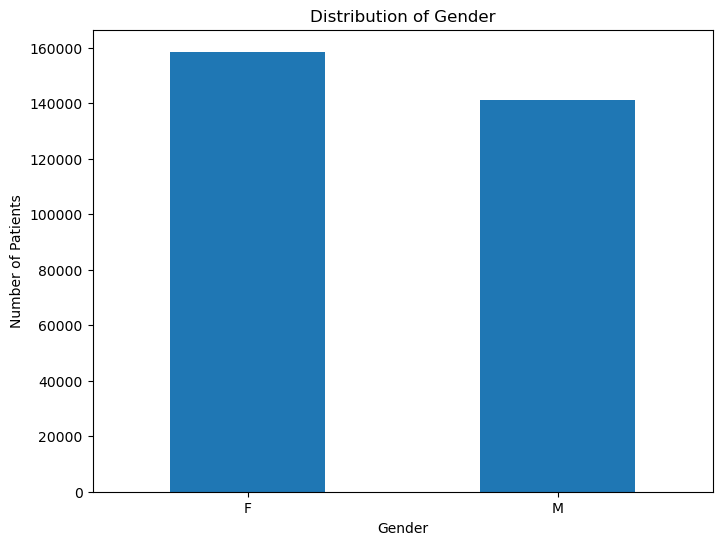

In [22]:
gender_counts = patients_df['gender'].value_counts()
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()


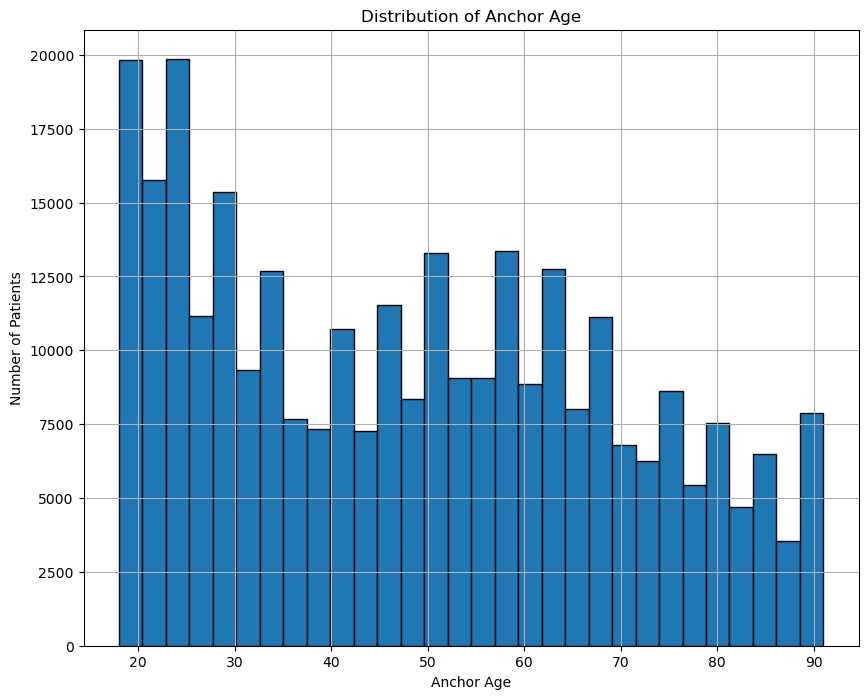

In [23]:
plt.figure(figsize=(10, 8))
patients_df['anchor_age'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Anchor Age')
plt.xlabel('Anchor Age')
plt.ylabel('Number of Patients')
plt.show()


Summary and Visualization of Gender and Anchor Age
1. Distribution of Anchor Age
Analysis:
The histogram shows the distribution of anchor age across patients.
The most common ages are in the early 20s, followed by a noticeable drop and then fluctuations across the different age ranges.
There are smaller peaks around ages 50, 60, and 70.
The age distribution is diverse but indicates higher admission rates among younger adults and a secondary peak in middle-aged to older adults.
The data suggests that both younger adults and older adults are significant portions of the ICU population, possibly due to different underlying health conditions.
2. Distribution of Gender
Analysis:
The bar chart shows the distribution of gender among patients.
There are more female patients (around 160,000) than male patients (around 140,000).
The gender distribution suggests a relatively balanced but slightly female-dominant population in the dataset.
Explanation of Patterns
Anchor Age:
Younger Adults: The high number of younger adults (especially in their early 20s) could be due to various factors, such as trauma, accidents, or specific medical conditions prevalent in younger populations.
Older Adults: Peaks around ages 50, 60, and 70 may indicate the increased prevalence of chronic diseases and age-related health issues that require ICU care.
Gender:
Female Dominance: The slightly higher number of female patients could reflect demographic trends in the population served by the hospital, differences in health-seeking behavior between genders, or the prevalence of certain conditions that are more common in females.
These visualizations provide a clearer picture of the demographic composition of the ICU patient population. Understanding these patterns is crucial for healthcare planning, resource allocation, and tailoring medical care to the needs of different patient groups.

## Problem 5. Lab results
labevents.csv.gz (https://mimic.mit.edu/docs/iv/modules/hosp/labevents/) contains all laboratory measurements for patients. The first 10 lines are

In [24]:
!zcat < ~/mimic/hosp/labevents.csv.gz | head

labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
1,10000032,,45421181,51237,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,1.4,1.4,,0.9,1.1,abnormal,ROUTINE,
2,10000032,,45421181,51274,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,___,15.1,sec,9.4,12.5,abnormal,ROUTINE,VERIFIED.
3,10000032,,52958335,50853,P28Z0X,2180-03-23 11:51:00,2180-03-25 11:06:00,___,15,ng/mL,30,60,abnormal,ROUTINE,NEW ASSAY IN USE ___: DETECTS D2 AND D3 25-OH ACCURATELY.
4,10000032,,52958335,50861,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,102,102,IU/L,0,40,abnormal,ROUTINE,
5,10000032,,52958335,50862,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,3.3,3.3,g/dL,3.5,5.2,abnormal,ROUTINE,
6,10000032,,52958335,50863,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,109,109,IU/L,35,105,abnormal,ROUTINE,
7,10000032,,52958335,50864,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,___,8,ng/mL,0,8.7,,ROUTI

`d_labitems.csv.gz` (https://mimic.mit.edu/docs/iv/modules/hosp/d_labitems/) is the dictionary of lab measurements.

In [25]:
!zcat < ~/mimic/hosp/d_labitems.csv.gz | head


itemid,label,fluid,category
50801,Alveolar-arterial Gradient,Blood,Blood Gas
50802,Base Excess,Blood,Blood Gas
50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
50804,Calculated Total CO2,Blood,Blood Gas
50805,Carboxyhemoglobin,Blood,Blood Gas
50806,"Chloride, Whole Blood",Blood,Blood Gas
50808,Free Calcium,Blood,Blood Gas
50809,Glucose,Blood,Blood Gas
50810,"Hematocrit, Calculated",Blood,Blood Gas


We are interested in the lab measurements of creatinine (50912), potassium (50971), sodium (50983), chloride (50902), bicarbonate (50882), hematocrit (51221), white blood cell count (51301), and glucose (50931). Retrieve a subset of `labevents.csv.gz` that only containing these items for the patients in `icustays_df`. Further restrict to the last available measurement (by `storetime`) before the ICU stay. The final `labevents_df` should have one row per ICU stay and columns for each lab measurement.
(ten columns with column names `subject_id`, `stay_id`, `Bicarbonate`, `Chloride`, ...)


_Hint_: Use the Parquet format you generated in Homework 3. For reproducibility, make `labevents.parquet` file available at the current working directory, for example, by a symbolic link.

In [26]:
# Import necessary libraries
import pandas as pd
import pyarrow.parquet as pq

# Define the list of itemids we are interested in
itemids = [50912, 50971, 50983, 50902, 50882, 51221, 51301, 50931]

# Load the lab items dictionary and filter the required items
dlabitems_tble = pd.read_csv("~/mimic/hosp/d_labitems.csv.gz")
dlabitems_tble = dlabitems_tble[dlabitems_tble['itemid'].isin(itemids)]

# Load ICU stays data
icustays_df = pd.read_csv("~/mimic/icu/icustays.csv.gz")

# Load and filter the lab events data
labevents_df = pq.ParquetDataset("labevents.parquet").read().to_pandas()
labevents_df = labevents_df[
    (labevents_df['itemid'].isin(itemids)) &
    (labevents_df['subject_id'].isin(icustays_df['subject_id']))
]

# Merge with ICU stays to get intime
labevents_df = pd.merge(
    labevents_df,
    icustays_df[['subject_id', 'stay_id', 'intime']],
    on='subject_id'
)

# Convert the storetime and intime to datetime
labevents_df['storetime'] = pd.to_datetime(labevents_df['storetime'])
labevents_df['intime'] = pd.to_datetime(labevents_df['intime'])

# Filter lab items to keep only those before ICU stay
labevents_df = labevents_df[labevents_df['storetime'] < labevents_df['intime']]

# Group by subject_id, stay_id, and itemid, then keep the last measurement before ICU stay
labevents_df = (
    labevents_df.sort_values('storetime')
    .groupby(['subject_id', 'stay_id', 'itemid'], as_index=False)
    .last()
)

# Pivot the table to have one row per ICU stay and columns for each lab measurement
labevents_df = labevents_df.pivot(index=['subject_id', 'stay_id'], columns='itemid', values='valuenum')

# Map item IDs to labels
column_mapping = dict(zip(dlabitems_tble['itemid'], dlabitems_tble['label']))
labevents_df = labevents_df.rename(columns=column_mapping)

# Reset index to make subject_id and stay_id columns
labevents_df = labevents_df.reset_index()

# Rename columns to more informative names
labevents_df.columns = ['subject_id', 'stay_id', 'Bicarbonate', 'Chloride', 'Creatinine', 'Glucose', 'Hematocrit', 'Potassium', 'Sodium', 'WBC']

# Display the final table
print(labevents_df)



       subject_id   stay_id  Bicarbonate  Chloride  Creatinine  Glucose  \
0        10000032  39553978         25.0      95.0         0.7    102.0   
1        10000980  39765666         21.0     109.0         2.3     89.0   
2        10001217  34592300         30.0     104.0         0.5     87.0   
3        10001217  37067082         22.0     108.0         0.6    112.0   
4        10001725  31205490          NaN      98.0         NaN      NaN   
...           ...       ...          ...       ...         ...      ...   
68462    19999442  32336619         28.0     105.0         0.9     95.0   
68463    19999625  31070865         20.0     115.0         3.2    248.0   
68464    19999828  36075953         14.0     104.0         0.7    334.0   
68465    19999840  38978960         25.0      98.0         0.8     85.0   
68466    19999987  36195440          NaN       NaN         1.4      NaN   

       Hematocrit  Potassium  Sodium   WBC  
0             6.7      126.0    41.1   6.9  
1        

In [27]:
# Save the final table if needed
labevents_df.to_csv('labevents_df.csv', index=False)

The final labevents_df has one row per ICU stay and columns for each lab measurement. It has 68467 rows and 10 columns. The first 5 lines are below:     
         subject_id   stay_id  Bicarbonate  Chloride  Creatinine  Glucose  \
0        10000032  39553978         25.0      95.0         0.7    102.0   
1        10000980  39765666         21.0     109.0         2.3     89.0   
2        10001217  34592300         30.0     104.0         0.5     87.0   
3        10001217  37067082         22.0     108.0         0.6    112.0   
4        10001725  31205490          NaN      98.0         NaN      NaN   

       Hematocrit  Potassium  Sodium   WBC  
0             6.7      126.0    41.1   6.9  
1             3.9      144.0    27.3   5.3  
2             4.1      142.0    37.4   5.4  
3             4.2      142.0    38.1  15.7  
4             4.1      139.0     NaN   NaN 

## Problem 6. Vitals from charted events

`chartevents.csv.gz` (https://mimic.mit.edu/docs/iv/modules/icu/chartevents/) contains all the charted data available for a patient. During their ICU stay, the primary repository of a patient’s information is their electronic chart. The `itemid` variable indicates a single measurement type in the database. The `value` variable is the value measured for `itemid`. The first 10 lines of `chartevents.csv.gz` are

In [28]:
!zcat < ~/mimic/icu/chartevents.csv.gz | head

subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220179,82,82,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220180,59,59,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220181,63,63,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220045,94,94,bpm,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220179,85,85,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220180,55,55,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220181,62,62,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220210,20,20,insp/min,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220277,95,95,%,0
zcat: error writing to output: Broken pipe


`d_items.csv.gz` (https://mimic.mit.edu/docs/iv/modules/icu/d_items/) is the dictionary for the itemid in `chartevents.csv.gz`.

In [29]:
!zcat < ~/mimic/icu/d_items.csv.gz | head

itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
220001,Problem List,Problem List,chartevents,General,,Text,,
220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,,Date and time,,
220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,,
220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,,
220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,,
220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,,Text,,
220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90,140
220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60,90
220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,,
zcat: error writing to output: Broken pipe


We are interested in the vitals for ICU patients: heart rate (220045), systolic non-invasive blood pressure (220179), diastolic non-invasive blood pressure (220180), body temperature in Fahrenheit (223761), and respiratory rate (220210). Retrieve a subset of `chartevents.csv.gz` only containing these items for the patients in `icustays_tble`. Further restrict to the first vital measurement within the ICU stay. The final `chartevents_tble` should have one row per ICU stay and columns for each vital measurement.

Hint: Use the Parquet format you generated in Homework 3. For reproducibility, make `chartevents.parquet` file available at the current working directory, for example, by a symbolic link.

In [1]:
# Import necessary libraries
import pandas as pd
import pyarrow.parquet as pq

# Define the list of itemids we are interested in
vital_itemids = [220045, 220179, 220180, 220210, 223761]

# Load the item dictionary and filter the required items
d_items_tble = pd.read_csv("~/mimic/icu/d_items.csv.gz")
d_items_tble = d_items_tble[d_items_tble['itemid'].isin(vital_itemids)]

# Load ICU stays data
icustays_df = pd.read_csv("~/mimic/icu/icustays.csv.gz")
icustays_df = icustays_df.sort_values(by=['subject_id', 'hadm_id'])

# Load and filter the chart events data
chartevents_df = pq.ParquetDataset("chartevents.parquet").read().to_pandas()
chartevents_df = chartevents_df[chartevents_df['itemid'].isin(vital_itemids)]

# Select relevant columns and join with ICU stays and item dictionary
chartevents_df = chartevents_df[['subject_id', 'stay_id', 'itemid', 'charttime', 'valuenum']]
chartevents_df = chartevents_df[chartevents_df['subject_id'].isin(icustays_df['subject_id'])]
chartevents_df = chartevents_df.merge(icustays_df[['stay_id', 'intime', 'outtime']], on='stay_id')

# Convert time columns to datetime
chartevents_df['charttime'] = pd.to_datetime(chartevents_df['charttime'])
chartevents_df['intime'] = pd.to_datetime(chartevents_df['intime'])
chartevents_df['outtime'] = pd.to_datetime(chartevents_df['outtime'])

# Filter the data to keep only those within ICU stay times
chartevents_df = chartevents_df[
    (chartevents_df['charttime'] >= chartevents_df['intime']) &
    (chartevents_df['charttime'] <= chartevents_df['outtime'])
]

# Group by subject_id, stay_id, and itemid, then keep the first measurement within ICU stay
chartevents_df = (
    chartevents_df.sort_values('charttime')
    .groupby(['subject_id', 'stay_id', 'itemid'], as_index=False)
    .first()
)

# Pivot the table to have one row per ICU stay and columns for each vital measurement
chartevents_df = chartevents_df.pivot(index=['subject_id', 'stay_id'], columns='itemid', values='valuenum')

# Map item IDs to labels
column_mapping = {
    220045: 'heart_rate',
    220179: 'sys_bp',
    220180: 'dias_bp',
    220210: 'resp_rate',
    223761: 'temp_f'
}
chartevents_df = chartevents_df.rename(columns=column_mapping)

# Reset index to make subject_id and stay_id columns
chartevents_df = chartevents_df.reset_index()

# Display the final table
print(chartevents_df)



itemid  subject_id   stay_id  heart_rate  sys_bp  dias_bp  resp_rate  temp_f
0         10000032  39553978        91.0    84.0     48.0       24.0    98.7
1         10000980  39765666        77.0   150.0     77.0       23.0    98.0
2         10001217  34592300        96.0   167.0     95.0       11.0    97.6
3         10001217  37067082        86.0   151.0     90.0       18.0    98.5
4         10001725  31205490        55.0    73.0     56.0       19.0    97.7
...            ...       ...         ...     ...      ...        ...     ...
73159     19999442  32336619        88.0   150.0     90.0       15.0    98.3
73160     19999625  31070865        96.0   152.0     74.0       19.0    98.9
73161     19999828  36075953       104.0   113.0     87.0       16.0    98.7
73162     19999840  38978960       100.0   114.0     64.0       16.0    99.3
73163     19999987  36195440        94.0   115.0     70.0       21.0    99.6

[73164 rows x 7 columns]


In [ ]:
#Save the final table 
chartevents_df.to_csv('chartevents_df.csv', index=False)

The final chartevents_df  has one row per ICU stay and columns for each vital measurement. It has 73164 rows and 7 colums, the first 5 lines are below: 
itemid  subject_id   stay_id  heart_rate  sys_bp  dias_bp  resp_rate  temp_f
0         10000032  39553978        91.0    84.0     48.0       24.0    98.7
1         10000980  39765666        77.0   150.0     77.0       23.0    98.0
2         10001217  34592300        96.0   167.0     95.0       11.0    97.6
3         10001217  37067082        86.0   151.0     90.0       18.0    98.5
4         10001725  31205490        55.0    73.0     56.0       19.0    97.7


## Problem 7. Putting things together
Let us create a data frame `mimic_icu_cohort` for all ICU stays, where rows are all ICU stays of adults (age at `intime` >= 18) and columns contain at least following variables

- all variables in `icustays_tble`
- all variables in `admissions_tble`
- all variables in `patients_tble`
- the last lab measurements before the ICU stay in `labevents_tble`
- the first vital measurements during the ICU stay in `chartevents_tble`
- The final `mimic_icu_cohort` should have one row per ICU stay and columns for each variable.

In [2]:
import pandas as pd

# Step 1: Read CSV Files
icustays_df = pd.read_csv("~/mimic/icu/icustays.csv.gz")
admissions_df = pd.read_csv("~/mimic/hosp/admissions.csv.gz")
patients_df = pd.read_csv("~/mimic/hosp/patients.csv.gz")

# Convert time columns to datetime
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
admissions_df['deathtime'] = pd.to_datetime(admissions_df['deathtime'])

# Step 2: Join DataFrames
merged_df = icustays_df.merge(admissions_df, on=['subject_id', 'hadm_id'], how='left')
merged_df = merged_df.merge(patients_df, on='subject_id', how='left')

# Step 3: Calculate Age and Filter for Adults
merged_df['age'] = merged_df['anchor_age'] + merged_df['intime'].dt.year - merged_df['anchor_year']
adult_patients_df = merged_df[merged_df['age'] >= 18]




In [3]:
labevents_df = pd.read_csv("labevents_df.csv")
chartevents_df = pd.read_csv("chartevents_df.csv")

In [4]:
# Merge Lab Events Data based on 'subject_id' and 'hadm_id'
merged_labs_df = adult_patients_df.merge(labevents_df, on=['subject_id', 'stay_id'], how='left')

In [5]:
# Step 6: Merge Chart Events Data based on 'subject_id' and 'stay_id'
mimic_icu_cohort = merged_labs_df.merge(chartevents_df, on=['subject_id', 'stay_id'], how='left')

# Step 7: Arrange and Collect Data
mimic_icu_cohort = mimic_icu_cohort.sort_values(by=['subject_id', 'stay_id'])

# Print the resulting DataFrame
print(mimic_icu_cohort)

       subject_id   hadm_id   stay_id  \
0        10000032  29079034  39553978   
1        10000980  26913865  39765666   
3        10001217  27703517  34592300   
2        10001217  24597018  37067082   
4        10001725  25563031  31205490   
...           ...       ...       ...   
73176    19999442  26785317  32336619   
73177    19999625  25304202  31070865   
73178    19999828  25744818  36075953   
73179    19999840  21033226  38978960   
73180    19999987  23865745  36195440   

                                         first_careunit  \
0                    Medical Intensive Care Unit (MICU)   
1                    Medical Intensive Care Unit (MICU)   
3                   Surgical Intensive Care Unit (SICU)   
2                   Surgical Intensive Care Unit (SICU)   
4      Medical/Surgical Intensive Care Unit (MICU/SICU)   
...                                                 ...   
73176               Surgical Intensive Care Unit (SICU)   
73177  Medical/Surgical Intensive C

In [6]:
# Save the final table if needed
mimic_icu_cohort.to_csv('mimic_icu_cohort.csv', index=False)

The final mimic_icu_cohort has one row per ICU stay and columns for each variable. It has 73181 rows and 41 columns, the first 5 lines are below:      
         subject_id   hadm_id   stay_id  \
0        10000032  29079034  39553978   
1        10000980  26913865  39765666   
3        10001217  27703517  34592300   
2        10001217  24597018  37067082   
4        10001725  25563031  31205490   
 

                                         first_careunit  \
0                    Medical Intensive Care Unit (MICU)   
1                    Medical Intensive Care Unit (MICU)   
3                   Surgical Intensive Care Unit (SICU)   
2                   Surgical Intensive Care Unit (SICU)   
4      Medical/Surgical Intensive Care Unit (MICU/SICU)   


                                          last_careunit              intime  \
0                    Medical Intensive Care Unit (MICU) 2180-07-23 14:00:00   
1                    Medical Intensive Care Unit (MICU) 2189-06-27 08:42:00   
3                   Surgical Intensive Care Unit (SICU) 2157-12-19 15:42:24   
2                   Surgical Intensive Care Unit (SICU) 2157-11-20 19:18:02   
4      Medical/Surgical Intensive Care Unit (MICU/SICU) 2110-04-11 15:52:22   


                  outtime       los           admittime           dischtime  \
0     2180-07-23 23:50:47  0.410266 2180-07-23 12:35:00 2180-07-25 17:55:00   
1     2189-06-27 20:38:27  0.497535 2189-06-27 07:38:00 2189-07-03 03:00:00   
3     2157-12-20 14:27:41  0.948113 2157-12-18 16:58:00 2157-12-24 14:55:00   
2     2157-11-21 22:08:00  1.118032 2157-11-18 22:56:00 2157-11-25 18:00:00   
4     2110-04-12 23:59:56  1.338588 2110-04-11 15:08:00 2110-04-14 15:00:00   


       ... Glucose Hematocrit Potassium Sodium   WBC heart_rate sys_bp  \
0      ...   102.0        6.7     126.0   41.1   6.9       91.0   84.0   
1      ...    89.0        3.9     144.0   27.3   5.3       77.0  150.0   
3      ...    87.0        4.1     142.0   37.4   5.4       96.0  167.0   
2      ...   112.0        4.2     142.0   38.1  15.7       86.0  151.0   
4      ...     NaN        4.1     139.0    NaN   NaN       55.0   73.0   
 

      dias_bp resp_rate temp_f  
0        48.0      24.0   98.7  
1        77.0      23.0   98.0  
3        95.0      11.0   97.6  
2        90.0      18.0   98.5  
4        56.0      19.0   97.7

## Problem 8. Exploratory data analysis (EDA)
Summarize the following information about the ICU stay cohort `mimic_icu_cohort` using appropriate method:

- Length of ICU stay `los` vs demographic variables (race, insurance, marital_status, gender, age at intime)

- Length of ICU stay `los` vs the last available lab measurements before ICU stay

- Length of ICU stay `los` vs the first vital measurements within the ICU stay

- Length of ICU stay `los` vs first ICU unit

At least two plots should be created, with at least one them including multiple facets using an appropriate keyword argument. 

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mimic_icu_cohort = pd.read_csv("mimic_icu_cohort.csv")
# Check the DataFrame to ensure it includes necessary columns
print(mimic_icu_cohort.columns)


Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'gender',
       'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'age',
       'Bicarbonate', 'Chloride', 'Creatinine', 'Glucose', 'Hematocrit',
       'Potassium', 'Sodium', 'WBC', 'heart_rate', 'sys_bp', 'dias_bp',
       'resp_rate', 'temp_f'],
      dtype='object')


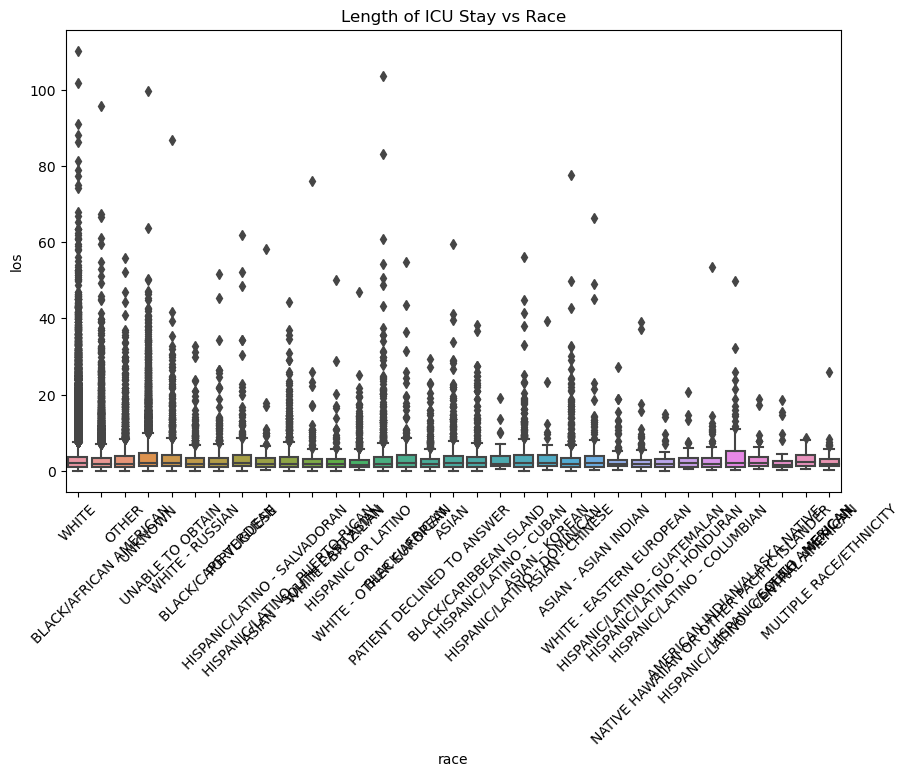

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mimic_icu_cohort, x='race', y='los')
plt.title('Length of ICU Stay vs Race')
plt.xticks(rotation=45)
plt.show()


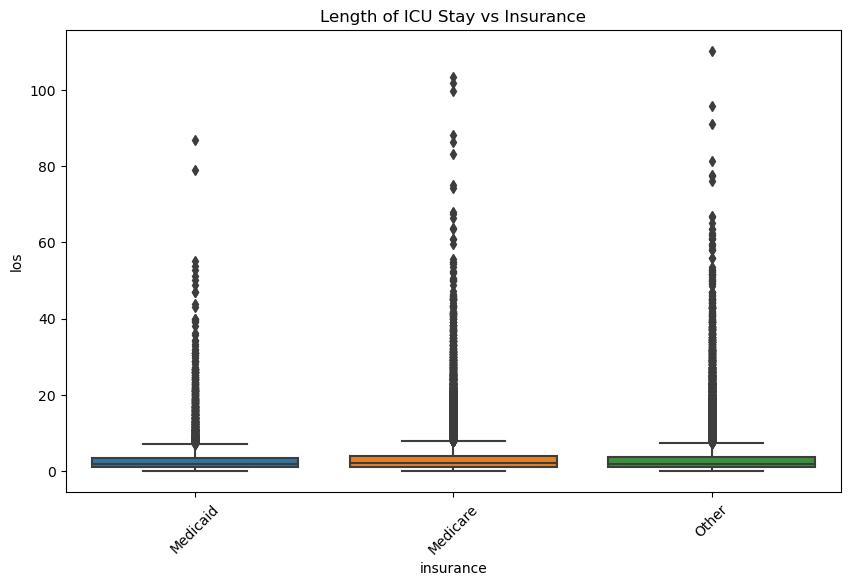

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mimic_icu_cohort, x='insurance', y='los')
plt.title('Length of ICU Stay vs Insurance')
plt.xticks(rotation=45)
plt.show()


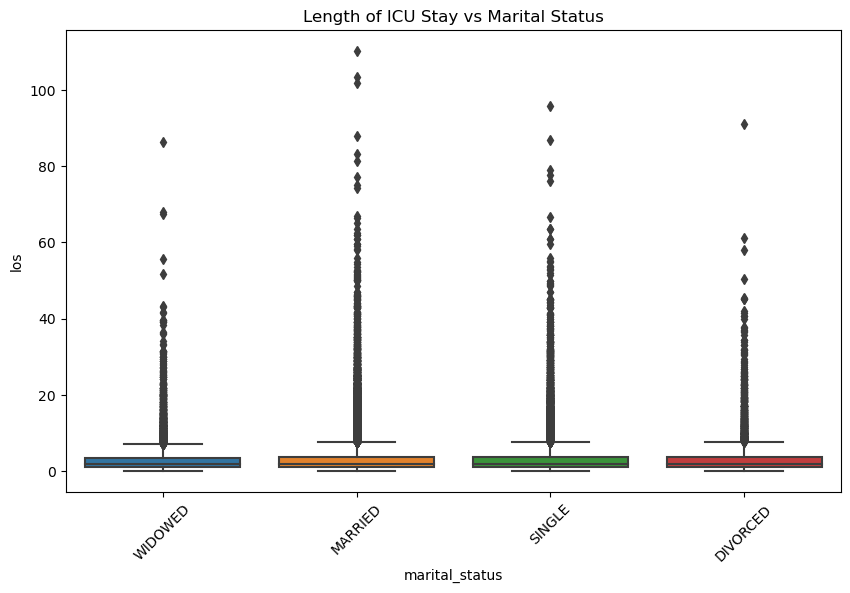

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mimic_icu_cohort, x='marital_status', y='los')
plt.title('Length of ICU Stay vs Marital Status')
plt.xticks(rotation=45)
plt.show()


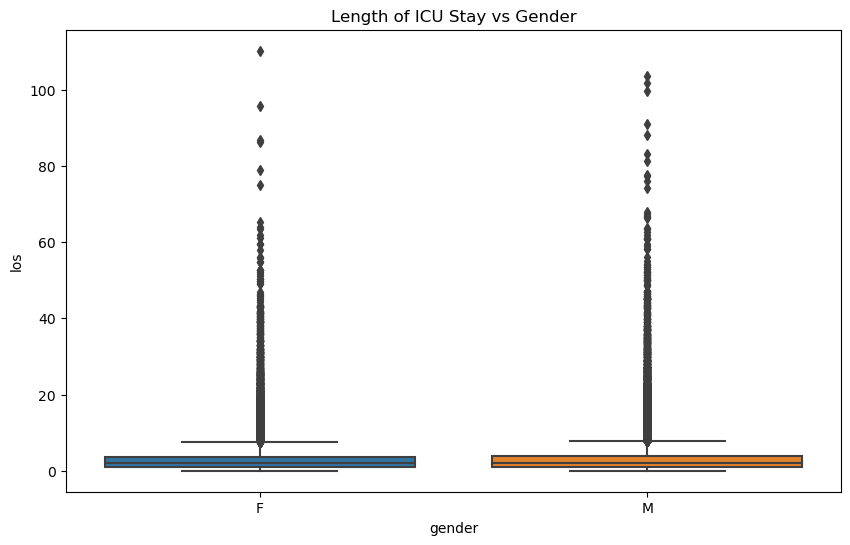

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mimic_icu_cohort, x='gender', y='los')
plt.title('Length of ICU Stay vs Gender')
plt.show()


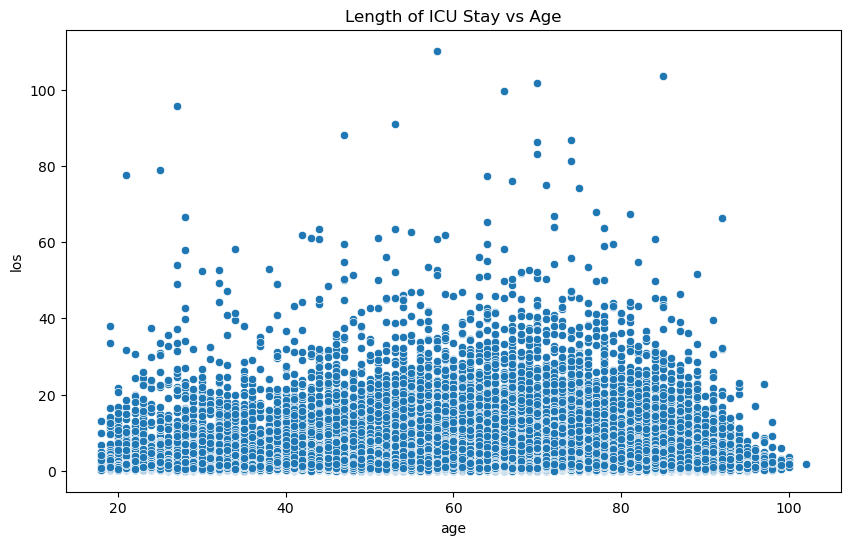

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mimic_icu_cohort, x='age', y='los')
plt.title('Length of ICU Stay vs Age')
plt.show()


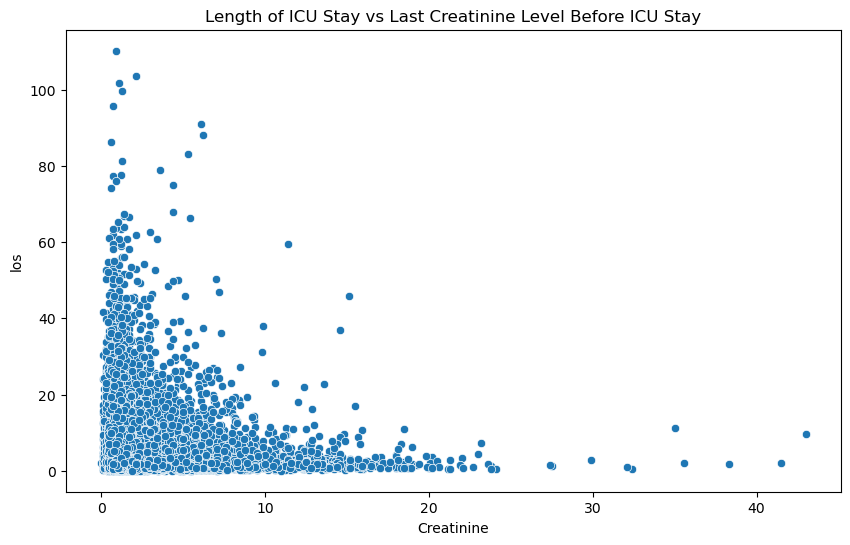

In [13]:
#  Length of ICU Stay vs Last Creatinine Level Before ICU Stay
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mimic_icu_cohort, x='Creatinine', y='los')
plt.title('Length of ICU Stay vs Last Creatinine Level Before ICU Stay')
plt.show()


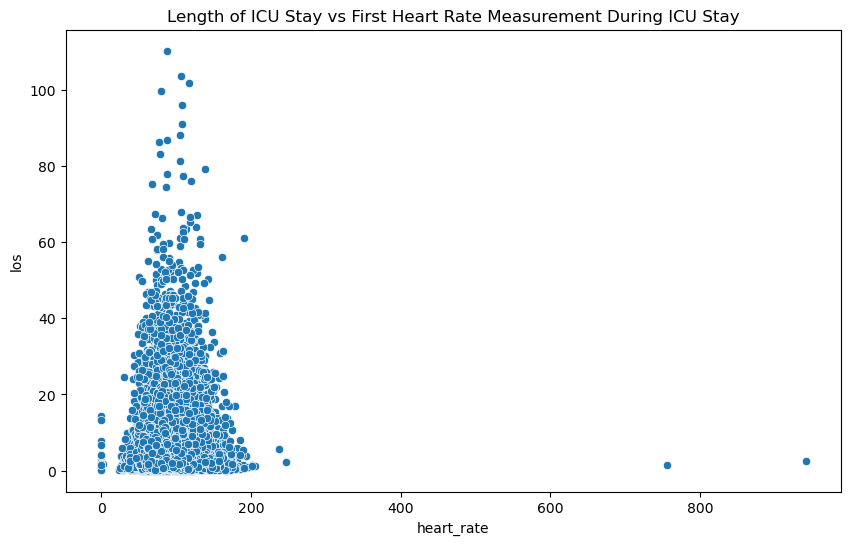

In [14]:
# Length of ICU Stay vs First Heart Rate Measurement During ICU Stay 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mimic_icu_cohort, x='heart_rate', y='los')
plt.title('Length of ICU Stay vs First Heart Rate Measurement During ICU Stay')
plt.show()


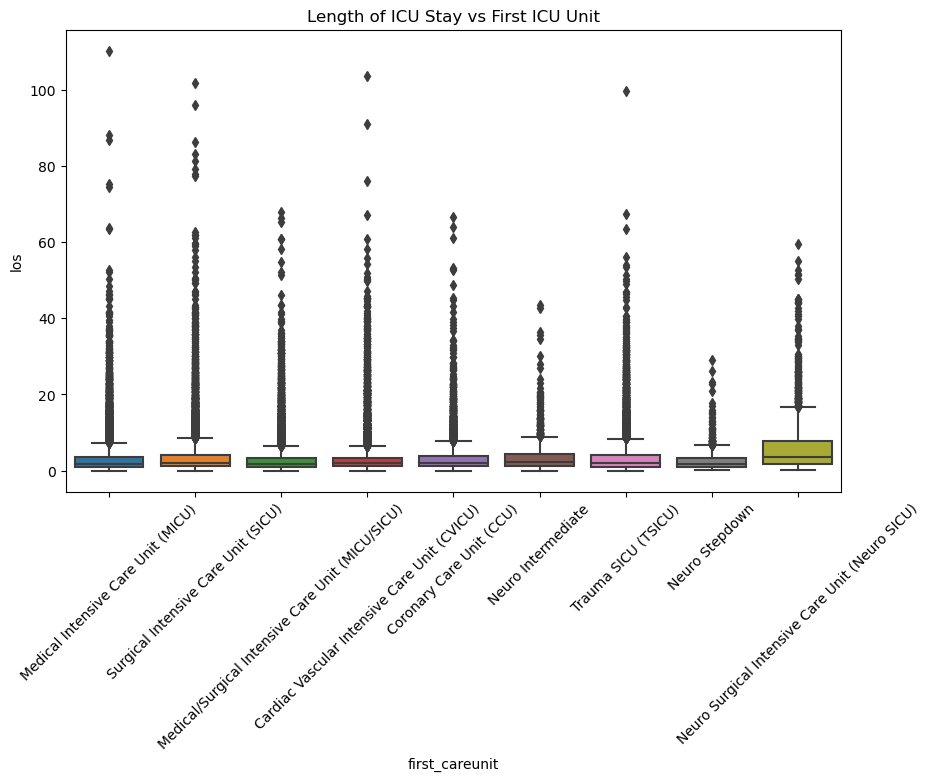

In [15]:
# Length of ICU Stay vs First ICU Unit
plt.figure(figsize=(10, 6))
sns.boxplot(data=mimic_icu_cohort, x='first_careunit', y='los')
plt.title('Length of ICU Stay vs First ICU Unit')
plt.xticks(rotation=45)
plt.show()


/opt/anaconda3/envs/BIOSTAT203C-24S/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


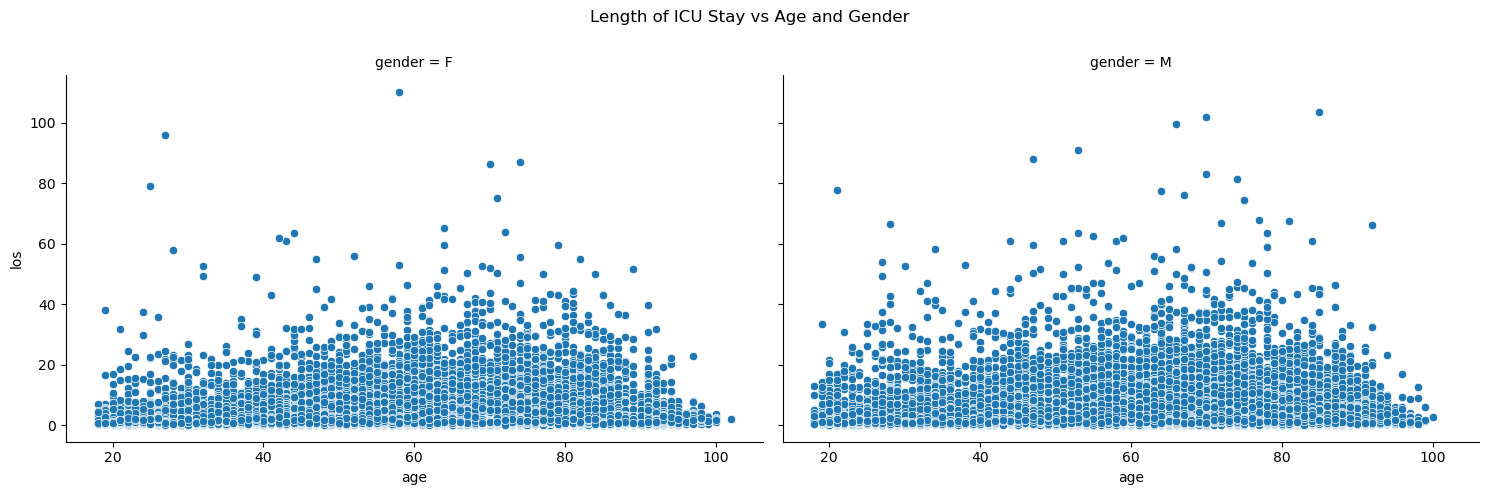

In [16]:
# Length of ICU Stay vs Age and Gender using multiple facets
g = sns.FacetGrid(mimic_icu_cohort, col='gender', height=5, aspect=1.5)
g.map(sns.scatterplot, 'age', 'los')
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Length of ICU Stay vs Age and Gender')
plt.show()


Analysis:
Length of ICU Stay vs Demographic Variables:
Race: The boxplot shows the distribution of ICU stay lengths across different racial categories. The medians and interquartile ranges (IQRs) can be compared to identify any differences among races.
Insurance: The boxplot shows the distribution of ICU stay lengths based on insurance type. Differences in stay lengths might reflect variations in healthcare access or policies.
Marital Status: The boxplot shows the distribution of ICU stay lengths across marital status categories. This can help identify if marital status impacts the duration of ICU stays.
Gender: The boxplot compares ICU stay lengths between males and females. It helps in understanding if there is any gender-based disparity in ICU stay durations.
Age: The scatter plot shows the relationship between age and ICU stay length. Trends or patterns (e.g., increased stay length with age) can be visualized.
Length of ICU Stay vs Lab Measurements:
Creatinine: The scatter plot shows the relationship between the last creatinine level before ICU stay and the length of ICU stay. High creatinine levels might indicate kidney issues, potentially leading to longer ICU stays.
Length of ICU Stay vs Vital Measurements:
Heart Rate: The scatter plot shows the relationship between the first heart rate measurement during the ICU stay and the length of ICU stay. Extreme heart rate values might correlate with longer ICU stays.
Length of ICU Stay vs First ICU Unit:
The boxplot shows the distribution of ICU stay lengths across different ICU units. Different ICU units might have varying average stay lengths due to the nature of the conditions they treat.
Facet Grid Plot:
The facet grid plot shows the relationship between age and ICU stay length, with separate plots for each gender. This helps in understanding the combined effect of age and gender on ICU stay lengths.
These visualizations provide insights into how demographic factors, lab measurements, and initial vital signs relate to the length of ICU stays. The boxplots and scatter plots help in identifying patterns and potential disparities, guiding further analysis and healthcare decisions.